In [8]:
__author__ = 'Dan Suson <djsuson@fnal.gov>' # single string; emails in <>
__version__ = '20210623' # yyyymmdd; version datestamp of this notebook
__datasets__ = ['delve_dr1','gaia_edr3']  # datasets used in this notebook; for available datasets, see cell "Available datasets in Data Lab" further below
__keywords__ = [''], # keywords relevant to this notebook, e.g. ['science case','dwarf galaxies'] Use only keywords from the master list: https://github.com/noaodatalab/notebooks-latest/blob/master/internal/keywords.txt

In [9]:
# std lib
from getpass import getpass

# 3rd party # remove imports that are not needed
import numpy as np
import pylab as plt
import matplotlib
import healpy as hp
import pandas as pd
%matplotlib inline

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc

In [18]:
# set up variable values to use in analysis
areas = [[-20,-10,180,195], [-30,-20,135,150]]
bands = ['g', 'r', 'i', 'z']
area = [-20,-10,180,195]
band = 'g'
lower_spread_limit = -0.025
upper_spread_limit = 0.045
lower_mag_limit = 13.5
upper_mag_limit = 26
min_spread = 0.003
wide_spread = 0.005
skim = 100
debug = False
bins = np.linspace(lower_mag_limit,upper_mag_limit)
centers = (bins[1:] + bins[:-1]) / 2.0

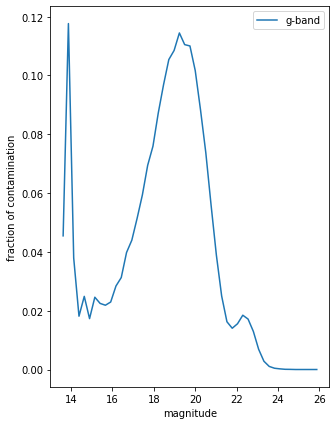

In [19]:
fig_hist, ax_hist = plt.subplots(1, 1, figsize=(5,7))

# getting necessary columns from DELVE within a certain RA and DEC
sql_delve =\
'''
SELECT quick_object_id,
spread_model_g,spreaderr_model_g,mag_auto_g,magerr_auto_g,
spread_model_r,spreaderr_model_r,mag_auto_r,magerr_auto_r,
spread_model_i,spreaderr_model_i,mag_auto_i,magerr_auto_i,
spread_model_z,spreaderr_model_z,mag_auto_z,magerr_auto_z
FROM delve_dr1.objects
WHERE dec>{:f} and dec<{:f} and ra>{:f} and ra<{:f}
'''.format(area[0],area[1],area[2],area[3])
delve_df = qc.query(sql=sql_delve,fmt='pandas')

# getting all objects from similar patch of sky from gaia x delve data
sql_gaia =\
'''
SELECT *
FROM gaia_edr3.x1p5__gaia_source__delve_dr1__objects
WHERE dec1>{:f} and dec1<{:f} and ra1>{:f} and ra1<{:f}
'''.format(area[0],area[1],area[2],area[3])
gaia_df = qc.query(sql=sql_gaia,fmt='pandas')

ids = np.array(gaia_df['id2']) # turn Delve IDs in the gaia dataset into an array

# convert to np arrays
indices = (delve_df[f'mag_auto_{band}'] > lower_mag_limit) & (delve_df[f'mag_auto_{band}'] < upper_mag_limit) \
        & (delve_df[f'spread_model_{band}'] > lower_spread_limit) & (delve_df[f'spread_model_{band}'] < upper_spread_limit)
quick_object_id = np.array(delve_df['quick_object_id'][indices])
mag_auto = np.array(delve_df[f'mag_auto_{band}'][indices])
spread_model = np.array(delve_df[f'spread_model_{band}'][indices])
spreaderr_model = np.array(delve_df[f'spreaderr_model_{band}'][indices])
matches = np.isin(quick_object_id,ids)

#calculate extended class value
three_sigma_extension = ((delve_df[f'spread_model_{band}'][indices]).values + 3*(delve_df[f'spreaderr_model_{band}'][indices]).values) > wide_spread
one_sigma_extension = ((delve_df[f'spread_model_{band}'][indices]).values + (delve_df[f'spreaderr_model_{band}'][indices]).values) > min_spread
bigger_than_PSF = ((delve_df[f'spread_model_{band}'][indices]).values - (delve_df[f'spreaderr_model_{band}'][indices]).values) > min_spread
   
extended_class = three_sigma_extension.astype(np.int16) + one_sigma_extension.astype(np.int16) + bigger_than_PSF.astype(np.int16)
extended_class_match = extended_class[matches]

# getting the magnitudes/spreads of objects that are matched with gaia
gaia_mags = delve_df[f'mag_auto_{band}'][indices][matches]
gaia_spreads = delve_df[f'spread_model_{band}'][indices][matches]
galaxy_ids = np.array(delve_df['quick_object_id'][indices][matches][extended_class_match>1])
galaxy_matches = np.isin(galaxy_ids,ids)
def_galaxy_ids = np.array(delve_df['quick_object_id'][indices][matches][extended_class_match>2])
def_galaxy_matches = np.isin(def_galaxy_ids,ids)
    
# print fractional overlap
if debug == True:
  print(f'Number of objects in Delve catalog for band {band}: ',len(spread_model))
  print(f'Number of objects/galaxies/definite galaxies in gaia catalog for band {band}: ',len(gaia_spreads),'/',len(galaxy_matches),'/',len(def_galaxy_matches))
  print(f'fraction of objects/galaxies/definite galaxies in gaia catalog for band {band}: %6.4f/%6.4f/%6.4f' \
          % (len(gaia_spreads)/len(spread_model), len(galaxy_matches)/len(spread_model), len(def_galaxy_matches)/len(spread_model)))

# create histogram for fraction of galaxies with matches in GAIA
galaxy_mags = np.array(delve_df[f'mag_auto_{band}'][indices][matches][extended_class_match>1][galaxy_matches])

gal_hist, _ = np.histogram(galaxy_mags, range=(lower_mag_limit,upper_mag_limit), bins=bins)
delve_hist, _ = np.histogram(mag_auto, range=(lower_mag_limit,upper_mag_limit), bins=bins)
ratio = (gal_hist / delve_hist).astype(float)
ax_hist.plot(centers, ratio, label=f'{band}-band')

ax_hist.set(xlabel='magnitude', ylabel='fraction of contamination')
ax_hist.legend()